In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import re
%matplotlib inline

1. While we have systematic checks in place to ensure the general system health of each compute node, we would like to use long-term data to see if there are any clusters of job failures on specific nodes. Do any of the production partition nodes show an unusual number of failed jobs relative to the others? Ignore the debug partition for this question.

2. The CMS collaboration has an automated job submission system that runs jobs as "cmslocal" and "cmspilot". For these two users, jobs have internal system tests that will terminate their jobs early after approximately 30 minutes. Do any of their jobs that ended in under an hour also cluster on specific compute nodes, suggesting possbily unreliable systems? Check both “production” and “nogpfs” partitions. Look for commonly failing nodes and compare with other failed jobs.

3. What groups are best optimizing their memory usage in terms of percent of actual memory used of the memory requested for a job? What is the average percent for each group?

4. Optimizing memory is more important for longer running jobs then shorter running jobs as the resources are tied up for longer. If jobs are weighted by runtime, what is the average percent of memory used of the requested memory for each group?

—QUESTION - If a project finishes early, does the machine move on to the next project, or does it sit empty for the remaining time?  
—NOTE - We will need to separately analyze single node jobs, so we can make sure there weren’t any nodes that were casualties of being partnered with faulty nodes.  
—QUESTION - Why do we get different results for ‘state=FAILURE’ and ‘exit code!=0’? Which is more accurate?  
—NOTE - For memory, drop rows that are RUNNING

In [4]:
accre = pd.read_csv('../data/accre-jobs-2020-cleaned.csv')

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
accre = accre[accre['state']!='RUNNING']
accre

,jobid,account,user,reqmemory,usedmemory,mem_diff,mem_pct_used,reqtime,usedtime,time_diff,time_pct_used,nodes,cpus,partition,exitcode_user,exitcode_node,state,nodelist,node_non_prod
0,16601402,mickey,dequan,5290.666667,1409.6,3881.066667,26.643145,1800000,1800022,-22,100.001222,1,24,cgw-dougherty1,0,0,COMPLETED,NaN,dougherty1
1,16724750,fava,jimena,102400.000000,70400.6,31999.400000,68.750586,1080000,1080025,-25,100.002315,1,1,cgw-capra1,0,0,COMPLETED,NaN,capra1
2,16930298,mangosteen,shenna,10240.000000,518.6,9721.400000,5.064453,720000,693761,26239,96.355694,1,4,cgw-cqs1,0,0,COMPLETED,NaN,cqs1
3,16950679,sprite,averi,15360.000000,2794.4,12565.600000,18.192708,432000,432009,-9,100.002083,1,1,pascal,0,0,COMPLETED,NaN,gpu0028
4,16959412,mangosteen,shenna,10240.000000,460.0,9780.000000,4.492188,720000,617694,102306,85.790833,1,4,cgw-cqs1,0,0,COMPLETED,NaN,cqs1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3864898,24173815_6,portabella,vennie,16384.000000,11634.5,4749.500000,71.011353,86400,96,86304,0.111111,1,2,production,0,0,COMPLETED,432.0,NaN
3864899,24173815_7,portabella,vennie,16384.000000,10439.9,5944.100000,63.720093,86400,97,86303,0.112269,1,2,production,0,0,COMPLETED,440.0,NaN
3864900,24173815_8,portabella,vennie,16384.000000,15021.3,1362.700000,91.682739,86400,147,86253,0.170139,1,2,production,0,0,COMPLETED,312.0,NaN
3864901,24173815_9,portabella,vennie,16384.000000,15533.9,850.100000,94.811401,86400,147,86253,0.170139,1,2,production,0,0,COMPLETED,312.0,NaN


In [6]:
#Drop inf rows on account CASABA
with pd.option_context('mode.use_inf_as_na', True):
    accre = accre.dropna(subset=['usedmemory','mem_diff','mem_pct_used'], how='all')

QUESTION 1: While we have systematic checks in place to ensure the general system health of each compute node, we would like to use long-term data to see if there are any clusters of job failures on specific nodes. Do any of the production partition nodes show an unusual number of failed jobs relative to the others? Ignore the debug partition for this question.

In [7]:
#QUESTION 1 - FIND MOST COMMONLY FAILING NODES. CODE OPTION #1 - based on the exit code
accre[accre['exitcode_node']!=0]['nodelist'].value_counts(sort=True).head(10)

405.0     13
1277.0    12
363.0     12
1437.0    11
304.0     10
1460.0    10
416.0     10
1298.0    10
1349.0    10
394.0      9
Name: nodelist, dtype: int64

In [8]:
#QUESTION 1 - FIND MOST COMMONLY FAILING NODES. CODE OPTION #2 - based on the state
accre[accre['state']=='FAILED']['nodelist'].value_counts(sort=True).head(10)

320.0     28
319.0     28
1423.0    27
1422.0    26
1424.0    26
374.0     25
496.0     25
347.0     24
411.0     23
410.0     23
Name: nodelist, dtype: int64

In [9]:
#QUESTION 1 - FIND MOST COMMONLY FAILING NODES. CODE OPTION #3 - based on the both
accre[(accre['state']=='FAILED') | (accre['exitcode_node']!=0)]['nodelist'].value_counts(sort=True).head(10)

320.0     34
319.0     34
374.0     33
405.0     32
1422.0    32
1423.0    32
496.0     31
1421.0    30
386.0     30
1437.0    30
Name: nodelist, dtype: int64

WORKING ON QUESTION TWO - REQUIRES DATASET WITH PRODUCTION AND NOGPFS
The CMS collaboration has an automated job submission system that runs jobs as "cmslocal" and "cmspilot". For these two users, jobs have internal system tests that will terminate their jobs early after approximately 30 minutes. Do any of their jobs that ended in under an hour also cluster on specific compute nodes, suggesting possbily unreliable systems? Check both “production” and “nogpfs” partitions. Look for commonly failing nodes and compare with other failed jobs.

In [10]:
accre.loc[accre['partition'].isin(['production', 'nogpfs'])].loc[accre['user'].isin(['cmslocal', 'cmspilot'])]

,jobid,account,user,reqmemory,usedmemory,mem_diff,mem_pct_used,reqtime,usedtime,time_diff,time_pct_used,nodes,cpus,partition,exitcode_user,exitcode_node,state,nodelist,node_non_prod
12,17032916,cms,cmspilot,2734.375000,1466.0,1268.375000,53.613714,172800,170875,1925,98.885995,1,8,nogpfs,0,0,COMPLETED,NaN,ng1037
13,17032920,cms,cmspilot,11806.375000,2582.4,9223.975000,21.872929,172800,170164,2636,98.474537,1,8,nogpfs,0,0,COMPLETED,NaN,ng691
14,17032921,cms,cmspilot,2734.750000,1483.9,1250.850000,54.260901,172800,171000,1800,98.958333,1,8,nogpfs,0,0,COMPLETED,NaN,ng719
15,17032923,cms,cmspilot,3582.833333,2171.1,1411.733333,60.597293,172800,170718,2082,98.795139,1,12,nogpfs,0,0,COMPLETED,NaN,ng210
16,17032930,cms,cmspilot,3838.833333,1991.5,1847.333333,51.877741,172800,171331,1469,99.149884,1,12,nogpfs,0,0,COMPLETED,NaN,ng1050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3864427,24172626,cms,cmspilot,7000.000000,5.1,6994.900000,0.072857,172800,86,172714,0.049769,1,4,production,0,0,COMPLETED,441.0,NaN
3864428,24172627,cms,cmspilot,7000.000000,5.1,6994.900000,0.072857,172800,86,172714,0.049769,1,4,production,0,0,COMPLETED,451.0,NaN
3864429,24172628,cms,cmspilot,7000.000000,5.1,6994.900000,0.072857,172800,86,172714,0.049769,1,4,production,0,0,COMPLETED,1471.0,NaN
3864430,24172629,cms,cmspilot,7000.000000,1.6,6998.400000,0.022857,172800,79,172721,0.045718,1,4,production,0,0,COMPLETED,1471.0,NaN


In [11]:
accre[accre['usedtime']<3600]['nodelist'].value_counts(sort=True).head(30)

1091.0    11312
304.0     10004
1367.0     9482
430.0      9078
425.0      8878
449.0      8870
416.0      8860
1321.0     8673
394.0      8462
383.0      8285
421.0      8199
463.0      8087
1266.0     7807
1438.0     7419
1095.0     7317
1467.0     7127
1082.0     7121
1472.0     7112
1468.0     7100
1088.0     7068
1449.0     7028
1121.0     7012
1436.0     6988
1457.0     6936
911.0      6808
1273.0     6786
382.0      6768
1278.0     6757
1471.0     6757
1481.0     6738
Name: nodelist, dtype: int64

In [12]:
accre[accre['usedtime']<3600]['node_non_prod'].value_counts(sort=True).head(30)

vm-cms-sam-pri    45761
vm-cms-sam-sec    33390
ng518             20731
ng1078             6597
ng1112             6560
ng1003             5852
ng1040             5841
ng1027             5788
ng507              5631
ng1067             5500
ng909              5297
cn1101             5283
ng205              4828
ng1020             4798
ng502              4745
ng1063             4684
ng688              4680
ng514              4635
ng915              4533
ng1014             4517
ng678              4473
ng1036             4473
ng734              4448
ng1080             4433
ng1061             4305
ng733              4111
ng1039             4078
ng512              3827
ng739              3683
ng1068             3589
Name: node_non_prod, dtype: int64

QUESTION THREE:  
What groups are best optimizing their memory usage in terms of percent of actual memory used of the memory requested for a job? What is the average percent for each group?

In [13]:
accre.drop_duplicates(subset='jobid', keep='first')

,jobid,account,user,reqmemory,usedmemory,mem_diff,mem_pct_used,reqtime,usedtime,time_diff,time_pct_used,nodes,cpus,partition,exitcode_user,exitcode_node,state,nodelist,node_non_prod
0,16601402,mickey,dequan,5290.666667,1409.6,3881.066667,26.643145,1800000,1800022,-22,100.001222,1,24,cgw-dougherty1,0,0,COMPLETED,NaN,dougherty1
1,16724750,fava,jimena,102400.000000,70400.6,31999.400000,68.750586,1080000,1080025,-25,100.002315,1,1,cgw-capra1,0,0,COMPLETED,NaN,capra1
2,16930298,mangosteen,shenna,10240.000000,518.6,9721.400000,5.064453,720000,693761,26239,96.355694,1,4,cgw-cqs1,0,0,COMPLETED,NaN,cqs1
3,16950679,sprite,averi,15360.000000,2794.4,12565.600000,18.192708,432000,432009,-9,100.002083,1,1,pascal,0,0,COMPLETED,NaN,gpu0028
4,16959412,mangosteen,shenna,10240.000000,460.0,9780.000000,4.492188,720000,617694,102306,85.790833,1,4,cgw-cqs1,0,0,COMPLETED,NaN,cqs1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3864898,24173815_6,portabella,vennie,16384.000000,11634.5,4749.500000,71.011353,86400,96,86304,0.111111,1,2,production,0,0,COMPLETED,432.0,NaN
3864899,24173815_7,portabella,vennie,16384.000000,10439.9,5944.100000,63.720093,86400,97,86303,0.112269,1,2,production,0,0,COMPLETED,440.0,NaN
3864900,24173815_8,portabella,vennie,16384.000000,15021.3,1362.700000,91.682739,86400,147,86253,0.170139,1,2,production,0,0,COMPLETED,312.0,NaN
3864901,24173815_9,portabella,vennie,16384.000000,15533.9,850.100000,94.811401,86400,147,86253,0.170139,1,2,production,0,0,COMPLETED,312.0,NaN


In [49]:
#accre[accre['state']!='FAILED'].groupby(
#    'account')[['account', 'mem_pct_used']].mean().sort_values('mem_pct_used').head(10)

In [15]:
#Find Top 10 accounts by average percent used
accre[accre['state']!='FAILED'].groupby(
    'account')[['account', 'mem_pct_used']].mean().sort_values('mem_pct_used').tail(10)

,mem_pct_used
account,
pinova,49.787233
summer,51.097208
roasted,52.037029
shiny,52.198011
shell,52.247972
chasselas,52.939618
shallots,56.994624
jicama,58.971547
strawberries,64.985253


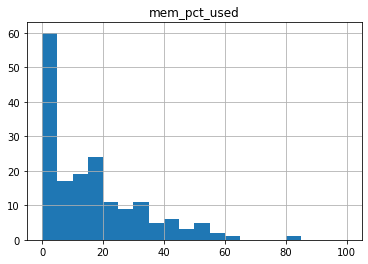

In [16]:
accre[accre['state']!='FAILED'].groupby(
    'account')[['account', 'mem_pct_used']].mean().hist(bins=20, range=(0,100));

In [17]:
#Alternate version, if we want to see more calculations of mem_diff_pct
#accre.groupby('account')[['account', 'mem_pct_used']].agg({'mem_pct_used': ['count', 'mean']})

In [18]:
#1 HIGHEST - horn - Looks to have a bunch where they only requested 1 MB.
accre[accre['state']!='FAILED'].loc[accre['account']=='horn'].sort_values('mem_pct_used')

,jobid,account,user,reqmemory,usedmemory,mem_diff,mem_pct_used,reqtime,usedtime,time_diff,time_pct_used,nodes,cpus,partition,exitcode_user,exitcode_node,state,nodelist,node_non_prod
1528127,19005116,horn,hjalmar,16384.0,0.0,16384.0,0.0,628200,15,628185,0.002388,1,4,production,0,0,COMPLETED,1228.0,NaN
899344,17724575,horn,hjalmar,16384.0,0.0,16384.0,0.0,628200,9,628191,0.001433,1,4,production,0,0,COMPLETED,427.0,NaN
2013973,19954861,horn,miya,256.0,0.0,256.0,0.0,628200,9,628191,0.001433,1,12,production,0,0,COMPLETED,373.0,NaN
2013974,19954862,horn,miya,256.0,0.0,256.0,0.0,628200,6,628194,0.000955,1,12,production,0,0,COMPLETED,373.0,NaN
2031923,19980284,horn,miya,3072.0,0.0,3072.0,0.0,628200,11,628189,0.001751,1,1,production,0,0,COMPLETED,304.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
832367,17580933,horn,miya,1.0,6.7,-5.7,670.0,628200,94,628106,0.014963,1,1,production,0,0,COMPLETED,430.0,NaN
832338,17580860,horn,miya,1.0,6.7,-5.7,670.0,628200,120,628080,0.019102,1,1,production,0,0,COMPLETED,430.0,NaN
832363,17580910,horn,miya,1.0,6.7,-5.7,670.0,628200,126,628074,0.020057,1,1,production,0,0,COMPLETED,421.0,NaN
832364,17580930,horn,miya,1.0,6.8,-5.8,680.0,628200,132,628068,0.021012,1,1,production,0,0,COMPLETED,430.0,NaN


In [19]:
#If we remove outliers, we see that "horn" is not in the highest level of percentage users.
accre[accre['state']!='FAILED'].loc[(accre['account']=='horn') & (accre['reqmemory'] > 1)]['mem_pct_used'].mean()

22.339764905255436

In [20]:
#2 HIGHEST - strawberries
accre[accre['state']!='FAILED'].loc[accre['account']=='strawberries'].sort_values('mem_pct_used')

,jobid,account,user,reqmemory,usedmemory,mem_diff,mem_pct_used,reqtime,usedtime,time_diff,time_pct_used,nodes,cpus,partition,exitcode_user,exitcode_node,state,nodelist,node_non_prod
263875,20624741,strawberries,arnav,19626.666667,0.0,19626.666667,0.000000,1800,5,1795,0.277778,1,6,debug,0,0,COMPLETED,NaN,cn371
2305131,20627165,strawberries,arnav,19626.666667,0.0,19626.666667,0.000000,10800,8,10792,0.074074,1,6,production,0,0,COMPLETED,1524.0,NaN
2328430,20687391,strawberries,arnav,19626.666667,0.0,19626.666667,0.000000,14400,6,14394,0.041667,1,6,production,0,0,COMPLETED,1365.0,NaN
2328813,20687902,strawberries,arnav,19626.666667,0.0,19626.666667,0.000000,14400,26,14374,0.180556,1,6,production,0,0,COMPLETED,1365.0,NaN
2423750,20867481,strawberries,arnav,19626.666667,0.0,19626.666667,0.000000,10800,8,10792,0.074074,1,6,production,0,0,COMPLETED,1355.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993129,19883289_23,strawberries,coleman,17920.000000,13936.0,3984.000000,77.767857,10800,4863,5937,45.027778,1,2,production,0,0,COMPLETED,1288.0,NaN
1993182,19883289_76,strawberries,coleman,17920.000000,13939.7,3980.300000,77.788504,10800,4298,6502,39.796296,1,2,production,0,0,COMPLETED,1232.0,NaN
2328843,20688024,strawberries,arnav,19626.666667,19533.7,92.966667,99.526325,14400,773,13627,5.368056,1,6,production,0,0,COMPLETED,1293.0,NaN
2328866,20688201,strawberries,arnav,19626.666667,19626.6,0.066667,99.999660,14400,834,13566,5.791667,1,6,production,0,0,COMPLETED,1281.0,NaN


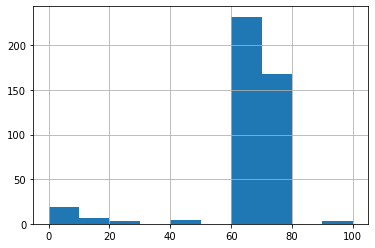

In [21]:
#2 HIGHEST - strawberries
accre[accre['state']!='FAILED'].loc[accre['account']=='strawberries']['mem_pct_used'].hist();

In [22]:
#3 HIGHEST - jicama
accre[accre['state']!='FAILED'].loc[accre['account']=='jicama'].sort_values('mem_pct_used')

,jobid,account,user,reqmemory,usedmemory,mem_diff,mem_pct_used,reqtime,usedtime,time_diff,time_pct_used,nodes,cpus,partition,exitcode_user,exitcode_node,state,nodelist,node_non_prod
1990861,19875061_325,jicama,gennaro,19626.666667,0.0,19626.666667,0.00000,216000,14745,201255,6.826389,1,12,production,0,0,COMPLETED,1293.0,NaN
1937285,19730391_2725,jicama,gennaro,25600.000000,0.0,25600.000000,0.00000,129600,1695,127905,1.307870,1,8,production,0,0,COMPLETED,1502.0,NaN
1937287,19730391_3025,jicama,gennaro,25600.000000,0.0,25600.000000,0.00000,129600,1868,127732,1.441358,1,8,production,0,0,COMPLETED,1494.0,NaN
1946912,19761854_3175,jicama,gennaro,19626.666667,0.0,19626.666667,0.00000,129600,69032,60568,53.265432,1,12,production,0,0,COMPLETED,1499.0,NaN
1992188,19880797_1525,jicama,gennaro,19626.666667,0.0,19626.666667,0.00000,216000,1991,214009,0.921759,1,12,production,0,0,COMPLETED,1297.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1937278,19730391_1675,jicama,gennaro,25600.000000,25600.0,0.000000,100.00000,129600,1976,127624,1.524691,1,8,production,0,0,COMPLETED,1497.0,NaN
1946904,19761854_1975,jicama,gennaro,19626.666667,19626.7,-0.033333,100.00017,129600,68703,60897,53.011574,1,12,production,0,0,COMPLETED,1502.0,NaN
1946896,19761854_775,jicama,gennaro,19626.666667,19626.7,-0.033333,100.00017,129600,72393,57207,55.858796,1,12,production,0,0,COMPLETED,1362.0,NaN
1946897,19761854_925,jicama,gennaro,19626.666667,19626.7,-0.033333,100.00017,129600,77862,51738,60.078704,1,12,production,0,0,COMPLETED,1383.0,NaN


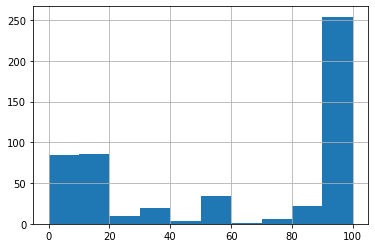

In [23]:
#3 HIGHEST - jicama
accre.loc[accre['account']=='jicama']['mem_pct_used'].hist();

In [24]:
#4 HIGHEST - shallots
accre[accre['state']!='FAILED'].loc[accre['account']=='shallots'].sort_values('mem_pct_used')

,jobid,account,user,reqmemory,usedmemory,mem_diff,mem_pct_used,reqtime,usedtime,time_diff,time_pct_used,nodes,cpus,partition,exitcode_user,exitcode_node,state,nodelist,node_non_prod
1743046,19370642_466,shallots,chrissie,5120.0,0.1,5119.9,0.001953,172800,156,172644,0.090278,1,1,production,0,0,COMPLETED,1135.0,NaN
963643,17867570_0,shallots,chrissie,12288.0,4.7,12283.3,0.038249,345600,65,345535,0.018808,1,1,production,0,0,COMPLETED,1278.0,NaN
963665,17867570_24,shallots,chrissie,12288.0,4.7,12283.3,0.038249,345600,88,345512,0.025463,1,1,production,0,0,COMPLETED,391.0,NaN
963664,17867570_23,shallots,chrissie,12288.0,4.7,12283.3,0.038249,345600,57,345543,0.016493,1,1,production,0,0,COMPLETED,1346.0,NaN
963663,17867570_22,shallots,chrissie,12288.0,4.7,12283.3,0.038249,345600,61,345539,0.017650,1,1,production,0,0,COMPLETED,1345.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1742987,19370642_407,shallots,chrissie,5120.0,5120.0,0.0,100.000000,172800,192,172608,0.111111,1,1,production,0,0,COMPLETED,421.0,NaN
1742631,19370642_50,shallots,chrissie,5120.0,5120.0,0.0,100.000000,172800,218,172582,0.126157,1,1,production,0,0,COMPLETED,1096.0,NaN
1742632,19370642_51,shallots,chrissie,5120.0,5120.0,0.0,100.000000,172800,169,172631,0.097801,1,1,production,0,0,COMPLETED,1124.0,NaN
1742967,19370642_387,shallots,chrissie,5120.0,5120.0,0.0,100.000000,172800,213,172587,0.123264,1,1,production,0,0,COMPLETED,421.0,NaN


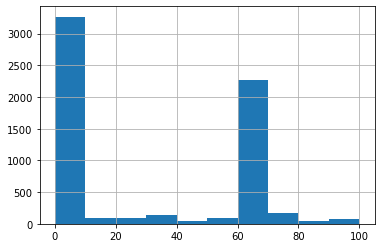

In [25]:
#4 HIGHEST - shallots
accre[accre['state']!='FAILED'].loc[accre['account']=='muscat']['mem_pct_used'].hist();

In [26]:
#GOAL - Make list of groups with under 1% average memory usage.
under_one = accre[accre['state']!='FAILED'].groupby('account')[['account', 'mem_pct_used']].mean()
under_one = under_one[under_one['mem_pct_used'] < 1].index.tolist()
under_one

['angelys',
 'basil',
 'cocktail',
 'discovery',
 'flamingo',
 'florence',
 'glasshouse',
 'golden',
 'grisette',
 'hass',
 'mung',
 'packham',
 'pinole',
 'plantain',
 'plumcot',
 'poblano',
 'president',
 'prince',
 'romanesco',
 'wa',
 'with']

In [50]:
#GOAL - Make list of groups with over 50% average memory usage.
over_fifty = accre[(accre['account'] != 'horn') & (accre['state']!='FAILED')].groupby(
    'account')[['account', 'mem_pct_used']].mean()
over_fifty = over_fifty[over_fifty['mem_pct_used'] > 50].sort_values(
    'mem_pct_used', ascending=False).index.tolist()
over_fifty

['strawberries',
 'jicama',
 'shallots',
 'chasselas',
 'shell',
 'shiny',
 'roasted',
 'summer']

In [51]:
#Groupby accounts, only looking at usedmem percentage
#accre[accre['state']!='FAILED'].groupby(
#'account')[['account', 'reqtime', 'mem_pct_used']].mean().sort_values(
#    'mem_pct_used').head(10)

QUESTION 4: Optimizing memory is more important for longer running jobs then shorter running jobs as the resources are tied up for longer. If jobs are weighted by runtime, what is the average percent of memory used of the requested memory for each group?

In [29]:
#Find weighted memory used percent
def weighted_memory(df):
    "Find the mean of each account's proportion of memory used, weighted by used time"
    
    #Multiple requested memory and used memory by used time, creating a "weighted" column for each
    df['weightreq'] = df['reqmemory'] * df['usedtime']
    df['weightused'] = df['usedmemory'] * df['usedtime']
   
    #Group by account, and find sum of above columns.
    groupedreq = df.groupby('account')[['account', 'weightreq']].sum()
    groupedused = df.groupby('account')[['account', 'weightused']].sum()
    
    #Merge the two grouped Series into one DataFrame
    grouped = groupedreq.merge(groupedused, on='account')
    
    #Divide total weighted used memory by total weighted requested memory, to find the weighted percentage used.
    grouped['weightmean'] = grouped['weightused'] / grouped ['weightreq'] * 100
    return grouped

accre = accre[accre['state']!='FAILED']
weighted_accounts = weighted_memory(accre)

In [30]:
#Find weighted time used percent
def weighted_time(df):
    "Find the mean of each account's proportion of memory used, weighted by used time"
    
    #Multiple requested memory and used memory by used time, creating a "weighted" column for each
    df['timereq'] = df['reqtime'] * df['usedtime']
    df['timeused'] = df['usedtime'] * df['usedtime']
   
    #Group by account, and find sum of above columns.
    groupedreqtime = df.groupby('account')[['account', 'timereq']].sum()
    groupedusedtime = df.groupby('account')[['account', 'timeused']].sum()
    
    #Merge the two grouped Series into one DataFrame
    groupedtime = groupedreqtime.merge(groupedusedtime, on='account')
    
    #Divide total weighted used memory by total weighted requested memory, to find the weighted percentage used.
    groupedtime['weightmeantime'] = groupedtime['timeused'] / groupedtime['timereq'] * 100
    return groupedtime

accre = accre[accre['state']!='FAILED']
weighted_time = weighted_time(accre)

In [31]:
weighted_time = pd.DataFrame(weighted_time)
weighted_accounts = pd.DataFrame(weighted_accounts)
weighted_visual = weighted_accounts.merge(weighted_time, on='account')

In [32]:
accrerows = accre[accre['state']!='FAILED'].groupby(
    'account')['account'].count()
accrerows = pd.DataFrame(accrerows)

In [33]:
accrerows.columns = [['totalrows']]
weighted_visual = weighted_visual.merge(accrerows, on='account')
weighted_visual = weighted_visual.drop(['weightreq', 'weightused', 'timereq', 'timeused'], axis=1)

In [34]:
weighted_visual.columns = [['weightmean', 'weightmeantime', 'totalrows']]

In [35]:
accrenodes = accre[accre['state']!='FAILED'].groupby(
    'account')[['account', 'nodes']].mean().sort_values('nodes')
weighted_visual = pd.merge(weighted_visual, accrenodes, on='account')
weighted_visual.columns = [['weightmean', 'weightmeantime', 'totalrows', 'nodes']]

In [39]:
weighted_visual = weighted_visual.reset_index()

In [48]:
#Weighted Scatterplot with point size representing the number of jobs per account
import plotly.express as px
df = px.data.gapminder()
fig = px.scatter(weighted_visual, x="weightmean", y="weightmeantime", size='totalrows',
           hover_name="account", log_x=False, size_max=60)
fig.update_layout(
    title="",
    xaxis_title="")
fig.show()

TypeError: only integer scalar arrays can be converted to a scalar index

In [47]:
#Weighted Scatterplot with point size representing the average number of used nodes per account
import plotly.express as px
df = px.data.gapminder()
fig = px.scatter(weighted_visual, x="weightmean", y="weightmeantime", size='nodes',
           hover_name="account", log_x=False, size_max=60)
fig.update_layout(
    title="",
    xaxis_title="")
fig.show()

SyntaxError: invalid syntax (<ipython-input-47-a158e3edaea0>, line 5)

In [ ]:
#TESTING WEIGHTED FUNCTION
#accre[accre['account']=='winged']['mem_pct_used'].mean()

In [ ]:
#TESTING WEIGHTED FUNCTION
#accre[accre['account']=='winged']['mem_pct_used'].hist();

In [ ]:
#TESTING WEIGHTED FUNCTION
#accre[accre['account']=='winged'].plot(kind='scatter', x='mem_pct_used', y='usedtime');

In [ ]:
weighted_under_one = weighted_accounts[weighted_accounts['weightmean']<1].index.tolist()
weighted_under_one

In [ ]:
weighted_over_fifty = weighted_accounts[
    weighted_accounts['weightmean']>50].sort_values(
    'weightmean', ascending=False).head(5).index.tolist()
weighted_over_fifty

VISUALIZATIONS:  
-Highest means vs average of all groups
~look at used time (does length affect it?)  
~nodes (do they happen to compare?)  
~usedmemory (tend to be larger/smaller?)  
~number of rows (maybe groups who do it more tend to get more accurate?)

In [ ]:
accre[accre['state']!='FAILED'].groupby(
    'account')[['account', 'time_pct_used']].mean().sort_values('time_pct_used')

In [ ]:
accre[accre['state']!='FAILED'].groupby(
    'account')[['account', 'nodes']].mean().sort_values('nodes')

In [ ]:
accre[accre['state']!='FAILED'].groupby(
    'account')['account'].count()

In [ ]:
accre[accre['usedtime']<1800][['nodelist', 'state']].groupby(
    'nodelist')